In [94]:
!pip install -q kaggle --quiet

In [95]:
!cp kaggle.json ~/.kaggle/

In [96]:
!kaggle datasets download -d wardaddy24/marble-surface-anomaly-detection

marble-surface-anomaly-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [97]:
!unzip marble-surface-anomaly-detection.zip 

Archive:  marble-surface-anomaly-detection.zip
replace marble/defect/IMG_20210525_133755.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace marble/defect/IMG_20210525_144257_LL.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [98]:
!pip install tensorflow --quiet
!pip install keras --quiet


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow 
from tensorflow import keras
from sklearn.model_selection import train_test_split
import keras as ks
import os
import cv2
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

warnings.filterwarnings('ignore')

In [100]:

data_dir = '/content/marble'

# create lists to store the image paths and labels
image_paths = []
labels = []

# iterate over the subdirectories for each class
for class_name in ['defect', 'good']:
    class_dir = os.path.join(data_dir, class_name)
    # iterate over the images in the class directory
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        # add the image path and label to the lists
        image_paths.append(image_path)
        labels.append(class_name)

# create a DataFrame with the image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# display the first few rows of the DataFrame
print(df.head())


                                          image_path   label
0  /content/marble/defect/IMG_20210525_151751_LL.jpg  defect
1  /content/marble/defect/IMG_20210525_144257_LL.jpg  defect
2  /content/marble/defect/IMG_20210525_151502_LL.jpg  defect
3  /content/marble/defect/IMG_20210531_105215_LL.jpg  defect
4  /content/marble/defect/IMG_20210531_105546_LL.jpg  defect


In [101]:
df['label'].value_counts()

good      35
defect    20
Name: label, dtype: int64

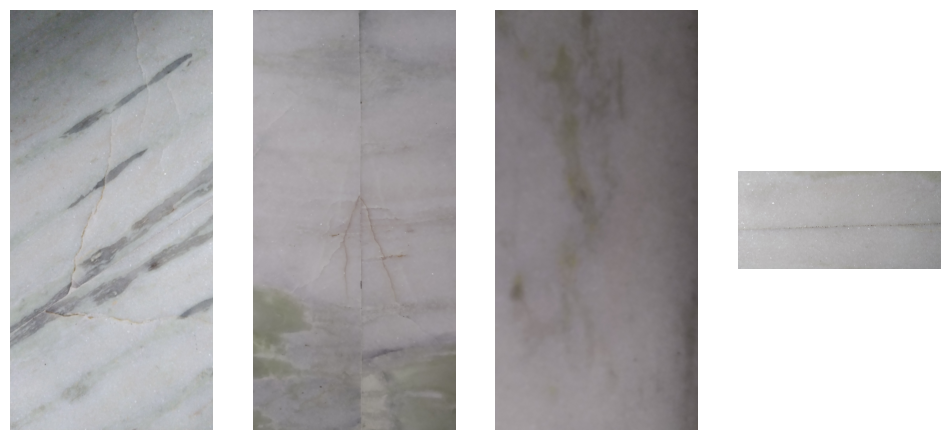

In [102]:
def visualize_images(image_paths):
    # create a figure with subplots
    fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 8))
    # iterate over the image paths and axes
    for image_path, ax in zip(image_paths, axes):
        # open the image
        image = Image.open(image_path)
        # plot the image
        ax.imshow(image)
        ax.axis('off')
    plt.show()

# get two images with defects and two that are good
defect_images = df[df['label'] == 'defect']['image_path'].sample(2)
good_images = df[df['label'] == 'good']['image_path'].sample(2)
image_paths = defect_images.tolist() + good_images.tolist()

# visualize the images
visualize_images(image_paths)


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  55 non-null     object
 1   label       55 non-null     object
dtypes: object(2)
memory usage: 1008.0+ bytes


In [104]:
df['label'].value_counts()

good      35
defect    20
Name: label, dtype: int64

In [105]:

# Data Preprocessing
image_size = (224, 224)
batch_size = 32

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    subset="training",
    class_mode="binary")

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="binary")

Found 44 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.


In [106]:
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras as ks

# Create a Model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 128)    512       
 chNormalization)                                                
                                                     

In [107]:
# compile the model with categorical crossentropy loss and accuracy metric
opt = ks.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping callback
callback = ks.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)

# train the model with early stopping callback and modified optimizer
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, batch_size=batch_size, callbacks=[callback])

Epoch 1/20
2/2 [==============================] - 55s 12s/step - loss: 1.5593 - accuracy: 0.6591 - val_loss: 0.7895 - val_accuracy: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 40s 14s/step - loss: 1.6073 - accuracy: 0.8182 - val_loss: 0.7413 - val_accuracy: 0.0909
Epoch 3/20
2/2 [==============================] - 38s 26s/step - loss: 0.7539 - accuracy: 0.8864 - val_loss: 0.6846 - val_accuracy: 0.4545
Epoch 4/20
2/2 [==============================] - 39s 26s/step - loss: 0.9830 - accuracy: 0.8182 - val_loss: 0.5989 - val_accuracy: 1.0000
Epoch 5/20
2/2 [==============================] - 38s 11s/step - loss: 0.7194 - accuracy: 0.8636 - val_loss: 0.5252 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 40s 12s/step - loss: 0.4040 - accuracy: 0.8409 - val_loss: 0.4900 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 47s 11s/step - loss: 0.4999 - accuracy: 0.9091 - val_loss: 0.4776 - val_accuracy: 1.0000
Epoch 8/20
2/2 [=======

In [ ]:
# Plot the loss function
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [116]:
model.save('marble_surface_model_final.h5')
files.download("marble_surface_model_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
from google.colab import files
import json
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("model_surface_model_2.json", "w") as json_file:
    json_file.write(model_json)

# Download JSON file
files.download("model_surface_model_2.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
import numpy as np
from tensorflow.keras.preprocessing import image

# load the test image
img_path = '/content/download (3).jpg'
img = image.load_img(img_path, target_size=image_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # normalize the image

# make predictions on the test image
predictions = model.predict(x)
if predictions[0][0] < 0.5:
    print("Defective")
else:
    print("Good")


1/1 [==============================] - 0s 247ms/step
Defective
